In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from os import listdir
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import cv2
import tqdm

/Users/eloise/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
IMG_SIZE = 224
STRIDE = 55
PATCH_SIZE = 55

In [3]:
def hide_patch(image, patch_size, patch_color, patch_position = None):
    
    assert patch_size%2==1, 'patch_size must be an odd number'
    
    hidden = image.copy()
    
    if patch_position is None:
        px = np.random.choice(IMG_SIZE)
        py = np.random.choice(IMG_SIZE)
    else:
        px = patch_position[0]
        py = patch_position[1]
    
    for i in range(px - patch_size//2, px + patch_size//2 + 1):
        for j in range(py - patch_size//2, py + patch_size//2 + 1):
            if i>=0 and i<IMG_SIZE and j>=0 and j<IMG_SIZE:
                hidden[i, j] = patch_color

    
    return hidden, [px, py]

## Create a dataset of all possible hidden images for one image

In [4]:
original = cv2.cvtColor(cv2.resize(cv2.imread('./images/tree.jpg'), (IMG_SIZE, IMG_SIZE)),  cv2.COLOR_RGB2BGR)

In [5]:
def generate_hidden_images(original, stride = 1):
    hidden_images = {}
    for x in tqdm.tqdm(range(0, IMG_SIZE, stride)):
        for y in range(0, IMG_SIZE, stride):
            hidden, _ = hide_patch(original, 25, [150, 150, 150], patch_position = [x, y])
            hidden_images[(x, y)] = hidden
    return hidden_images


In [6]:
hidden_images = generate_hidden_images(original, PATCH_SIZE)

100%|██████████| 5/5 [00:00<00:00, 232.75it/s]


In [7]:
n = len(hidden_images)
n

25

In [8]:
flatten = []
for k in hidden_images.keys():
    flatten.append(hidden_images[k])
flatten.append(original) # the last one is the original one
flatten = np.array(flatten)

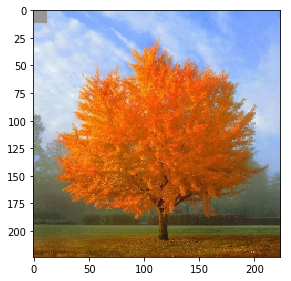

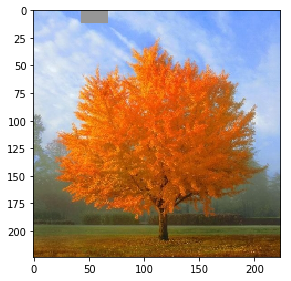

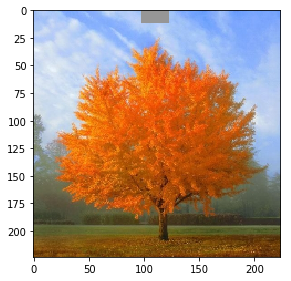

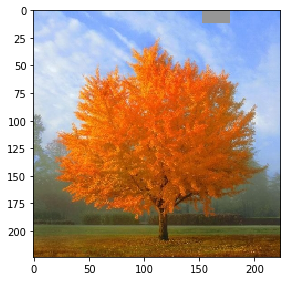

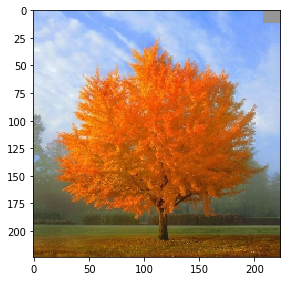

In [9]:
for image in flatten[:5]:
    plt.figure(figsize = (15, 10))

    plt.subplot(221)

    plt.imshow(image)

In [10]:
to_recognize = tf.convert_to_tensor(flatten)

## Pass it to VGG16

In [11]:
vgg16 = VGG16(include_top=True, weights='imagenet', input_tensor=None,
                               input_shape=None, pooling=None, classes=1000)

In [12]:
res_hidden = vgg16.predict(to_recognize, steps = n, verbose = 1)
preds = decode_predictions(res_hidden, top=5)

25/25 [==============================] - 391s 16s/step


Reconstruct an image with top predictions

In [13]:
res_dict = {}
k = 0
for i in range(0, IMG_SIZE, STRIDE):
    for j in range(0, IMG_SIZE, STRIDE):
        res_dict[(i, j)] = preds[k]
        k+=1
res_dict[(-1, -1)] = preds[-1]

In [14]:
len(res_dict.keys())

26

In [15]:
labels = []
for i in res_dict.keys():
    print(i, res_dict[i][0][1])
    if res_dict[i][0][1] not in labels:
        labels.append(res_dict[i][0][1])

(0, 0) lakeside
(0, 55) seashore
(0, 110) lakeside
(0, 165) lakeside
(0, 220) lakeside
(55, 0) lakeside
(55, 55) lakeside
(55, 110) seashore
(55, 165) lakeside
(55, 220) lakeside
(110, 0) lakeside
(110, 55) lakeside
(110, 110) seashore
(110, 165) seashore
(110, 220) lakeside
(165, 0) lakeside
(165, 55) lakeside
(165, 110) lakeside
(165, 165) seashore
(165, 220) lakeside
(220, 0) lakeside
(220, 55) lakeside
(220, 110) lakeside
(220, 165) lakeside
(220, 220) lakeside
(-1, -1) seashore


In [21]:
mask = original * 0

In [22]:
colors = 255 * np.random.rand(len(labels), 3)

In [23]:
for px in range(0, IMG_SIZE, STRIDE):
    for py in range(0, IMG_SIZE, STRIDE):
        c = colors[labels.index( res_dict[(px, py)][0][1],0)]
        for i in range(px - PATCH_SIZE//2, px + PATCH_SIZE//2 + 1):
            for j in range(py - PATCH_SIZE//2, py + PATCH_SIZE//2 + 1):
                if i>=0 and i<IMG_SIZE and j>=0 and j<IMG_SIZE:
                    mask[i, j] = c

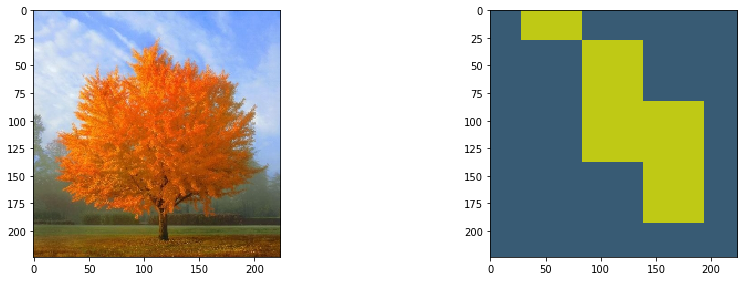

In [24]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

plt.imshow(original)

plt.subplot(222)

plt.imshow(mask)
#plt.legend(labels)

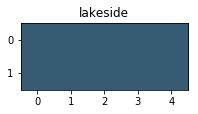

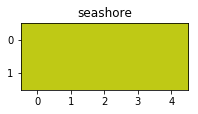

In [30]:
for i in range(len(labels)):
    plt.figure(figsize = (3, 3))
    blank_image = np.zeros((2, 5,3), np.uint8)
    for x in range(2):
        for y in range(5):
            blank_image[x, y, :] = colors[i]
    plt.imshow(blank_image)
    plt.title(labels[i])